# DESI PV Y3 Group/Cluster TFR Calibration

Using the list of groups defined by Tully in [*Galaxy Groups: a 2MASS Catalog*](https://iopscience.iop.org/article/10.1088/0004-6256/149/5/171), AJ 149:171, 2015, identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-cluster joint fit to calibrate the TFR at $0.4R_{26}$.

Version: **May 20, 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

Changes I am adding:
- Adding $V_{max}$ weighting
- Implementing coordinate corrections
- Adjusting cluster membership

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 clusters, so we need to change the default color map so that they are all plotted with different colors
from cycler import cycler
import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle
import requests
import matplotlib.patheffects as patheffects

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/s/sgmoore1/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.

H0 = 100*h
q0 = 0.2

# Access SGA Jura Data

In [3]:
sgatab_sel = Table.read('SGA-2020_jura_Vrot_VI_ML_photocorr.fits')
sgatab_sel[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,R26_kpc,R26_kpc_err,R_ABSMAG_SB26_CORR,D26_kpc,DIST_MAX,MAX_VOL_FRAC,MORPHTYPE_AI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,kpc,kpc,,
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes10
32,SGA-2020 32,PGC2644444,2644444,212.02461,62.8385803,Sc,26.25,0.3758374,0.60255957,0.09556411,23.73748,17.234,False,LEDA-20181114,10,PGC2644444,1,True,212.02461,62.8385803,0.3758374,2122p627,212.02462598739942,62.838526399057336,0.68802845,SB26,22.800411,0.4168182,212.02444469714254,62.83861910315144,15.352884,7.5523267,7.0574827,6.552769,6.8422165,9.006861,11.119019,13.218836,14.83576,16.089632,17.419872,18.262827,20.640854,17.682621,16.800076,16.140163,17.36588,16.500635,15.859558,17.164816,16.315928,15.683345,17.029795,16.192858,15.569851,16.956533,16.127148,15.511885,16.912262,16.09487,15.481129,16.881954,16.068357,15.467079,16.868856,16.055609,15.458797,16.854921,16.045063,15.448293,0.076427355,0.10654599,0.14980716,0.14600274,0.17229652,0.11901944,0.1291893,0.1625502,0.3402725,0.028715666,0.03028943,0.031358354,0.026863642,0.028016893,0.029046243,0.025209688,0.026244337,0.027134262,0.023817942,0.024750203,0.025650727,0.022882456,0.023803

## Load SN Ia Calibrators for the TFR Zero Point

List of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA Jura observations that have passed all quality cuts.

In [5]:
# zeroptab = Table.read('SGA-2020_jura_Vrot_VI_0ptPRIMARY_calib_z0p1.fits')

#### if we only want primary matches
zeroptab = Table.read('SGA-2020_jura_Vrot_VI_0pt_calib_z0p1.fits')

# use_primary = zeroptab['MU_SECONDARY'] < 0
# mu = zeroptab['MU_SECONDARY']
# mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]

# Access Williams Cluster Catalog

These groups come from the group catalog being created by Ian Williams, still a work in progress as of April 2025. The cluster membership is explicity defined in this catalog

In [6]:
clusters = Table.read('/global/cfs/cdirs/desi/users/ianw89/groupcatalogs/BGS_Y3/v0.3/GROUP_CATALOG_BGS_Y3_v0.3.fits')
print(len(clusters), 'galaxies')
clusters[:5]

7208203 galaxies


TARGETID,RA,DEC,Z,L_GAL,VMAX,P_SAT,M_HALO,N_SAT,L_TOT,IGRP,WEIGHT,APP_MAG_R,Z_ASSIGNED_FLAG,G_R,IS_SAT,QUIESCENT,MSTAR
,deg,deg,,solLum,Mpc3,,solMass,,solLum,,,,,,,,solMass
int64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int64,float64,float64,int32,float64,bool,bool,float64
39627351755068123,49.834953,-18.154497,0.223119,9910589000.0,500591000.0,0.0,926257900000.0,0,9910589000.0,0,0.304398,19.01287078857422,8,0.47272672668586324,False,False,--
39627351755069619,49.884101,-18.144277,0.077145,23113710000.0,3227000000.0,0.0,5430847000000.0,1,25390040000.0,1,0.417608,15.423483848571777,0,0.9535473819332729,False,True,81316050547.84206
39627351755069935,49.893713,-18.130689,0.23327,11987980000.0,577848500.0,0.0,2062001000000.0,0,11987980000.0,2,0.444981,19.000844955444336,0,0.8095572583204103,False,True,--
39627351759257696,49.928422,-18.144042,0.233045,10453490000.0,470522800.0,0.0,4801728000000.0,1,20394420000.0,3,0.450694,19.1475772857666,1,0.9369175687043381,False,True,--
39627351759257779,49.930442,-18.146842,0.233045,9940930000.0,522359000.0,0.972621,4801728000000.0,1,20394420000.0,3,0.304131,19.071929931640625,0,0.3366529553781312,True,False,--


# Find Group Membership
Each galaxy in the Williams catalog is assigned to a group. So, we just need to match our galaxies to those in the Williams catalog. We perform this matching using the targetids in `Catalog_Matching_Williams.ipynb`, so we can read in the file that contains the groups corresponding to each of our SGA_IDs, and then append this to our table.

In [7]:
target_matches = Table.read('Jura_Williams_Y3_TargetID_Matches.fits')

sgatab = join(target_matches, sgatab_sel, keys='SGA_ID', join_type='inner')

## rename the group ids for consistency later
sgatab['CLUSTER_ID'] = sgatab['IGRP']
sgatab['SGA_ID', 'RA', 'DEC', 'D26','CLUSTER_ID'][:5]

SGA_ID,RA,DEC,D26,CLUSTER_ID
int64,float64,float64,float32,int64
32,212.02462598739942,62.838526399057336,0.68802845,6728502
38,211.66203166014844,39.52724032794356,0.41757938,5447305
53,255.6410175635765,36.68179095091098,0.38201582,5259463
55,199.73062047638814,1.7262730115560398,0.4956815,1606495
63,234.87534259414386,19.697185738728333,0.6503176,3846903


Let's get a sense of how large our groups are.

In [8]:
group, grp_count = np.unique(sgatab['CLUSTER_ID'], return_counts = True)
print('3+ galaxies:', np.sum(grp_count >= 3))
print('5+ galaxies:', np.sum(grp_count >= 5))
print('8+ galaxies:', np.sum(grp_count >= 8))
print('10+ galaxies:', np.sum(grp_count >= 10))

3+ galaxies: 96
5+ galaxies: 17
8+ galaxies: 5
10+ galaxies: 5


# Find Clusters with at least 8 Galaxies

In [9]:
#### only keep clusters with at least 8 gals
sga_groups = {
    group[i]: list(sgatab['SGA_ID'][sgatab['CLUSTER_ID'] == group[i]])
    for i in range(len(group))
    if grp_count[i] >= 10
}

In [10]:
#### print out the good clusters and their counts
for i, (cluster_id, sga_ids) in enumerate(sga_groups.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies')

 1 1563749  10 galaxies
 2 3460920  22 galaxies
 3 3699706  13 galaxies
 4 5127507  10 galaxies
 5 5451736  25 galaxies


## Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

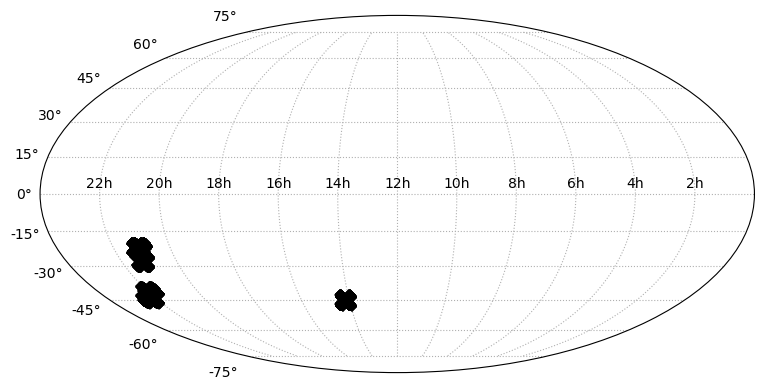

In [11]:
nest_ids = np.asarray(list(sga_groups.keys()))
idx = np.in1d(clusters['IGRP'], nest_ids)
cluster_lon = clusters['RA'][idx]
cluster_lat = clusters['DEC'][idx]
cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in cluster_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_clusters_20241203.png', dpi=150);


In [12]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def cluster_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a cluster.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the clusters coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [13]:
def plot_cluster_members(clusters, cluster_id, sgacat, sga_ids):
    """Generate a set of diagnostic plots for the members of a cluster.
    """
    # Get Williams cluster members (full set)
    idx_williams = np.in1d(clusters['IGRP'], cluster_id)
    cluster_galaxies = clusters[idx_williams]
    cluster_coord = SkyCoord(ra=cluster_galaxies['RA'], dec=cluster_galaxies['DEC'], unit='deg', frame='icrs')

    
    z_cluster = clusters['Z'][idx_williams]
    z_sort_williams = np.sort(z_cluster)
    n_gal = len(z_sort_williams)
    z_cluster_median = np.mean(z_sort_williams[n_gal//2:n_gal//2 + 2]) if (n_gal % 2 == 0) else z_sort_williams[n_gal//2]
    
    cluster_coords_median = cluster_median_coords(cluster_coord)

    # Get observed (SGAcat) galaxies for this cluster (subset)
    idx_sga = np.in1d(sgacat['CLUSTER_ID'], cluster_id)
    
    z_sga = sgacat['Z_DESI'][idx_sga]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    
    sga_subset = sgacat[idx_sga]
    sga_coords = SkyCoord(ra=sga_subset['RA'], dec=sga_subset['DEC'], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    # Calculate angular distances from cluster center for both catalogs
    separations_williams = cluster_coord.separation(sga_coords_median)
    separations_sga = sga_coords.separation(sga_coords_median)

    # Determine max radius to cover all galaxies in both catalogs
    max_sep_williams = np.max(separations_williams) if len(separations_williams) > 0 else 0
    max_sep_sga = np.max(separations_sga) if len(separations_sga) > 0 else 0
    radius = max(max_sep_williams, max_sep_sga)

    # Plot
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=sga_coords_median, radius=1.2*radius)
    ax.grid()

    # Plot all Williams galaxies
    ax.plot(cluster_coord.ra.deg, cluster_coord.dec.deg, '.', color='blue',
            transform=ax.get_transform('world'), alpha=0.2, label='Williams catalog')

    # Plot observed galaxies
    ax.plot(sga_coords.ra.deg, sga_coords.dec.deg, 'o', color='green',
            transform=ax.get_transform('world'), alpha=0.8, label='Observed (SGAcat)', zorder=10)

    # Mark cluster center and sga center
    ax.plot(sga_coords_median.ra.deg, sga_coords_median.dec.deg, 'rD',
            transform=ax.get_transform('world'), ms=8, mew=2)
    ax.plot(cluster_coords_median.ra.deg, cluster_coords_median.dec.deg, 'kx',
            transform=ax.get_transform('world'), ms=8, mew=2)

    # Circle showing extent of the cluster
    circle = SphericalCircle(sga_coords_median, radius, transform=ax.get_transform('world'),
                             edgecolor='tab:green', linestyle='dashed', facecolor='none')
    ax.add_patch(circle)

    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')
    # ax.legend()


    #- Plot the Dec vs redshift and velocity limits
    ax = plt.subplot(232)
    ax.plot(z_cluster, cluster_coord.dec.deg, '.', color='blue', alpha=0.2, label=f'{cluster_id}')
    ax.plot(z_sga, sga_coords.dec.deg, 'o', color='green', alpha=0.8, label=f'{cluster_id}')
    ax.plot(z_sga_median, sga_coords_median.dec.deg, 'rD', ms=5, mew=5)
    ax.plot(z_cluster_median, cluster_coords_median.dec.deg, 'kx', ms=5, mew=5)
    
    # ax.plot(cluster_v/c_kms, cluster_coord.dec.deg, 'kx', ms=10, mew=5)

    decmin = min(np.min(cluster_coord.dec.deg), np.min(sga_coords.dec.deg) ) - 0.5
    decmax = max(np.max(cluster_coord.dec.deg), np.max(sga_coords.dec.deg) ) + 0.5

    # ax.vlines(np.asarray([cluster_v-3*cluster_sigma,
    #                       cluster_v+3*cluster_sigma,
    #                       cluster_v-2*cluster_sigma,
    #                       cluster_v+2*cluster_sigma])/c_kms,
    #           decmin, decmax,
    #           colors='tab:blue',
    #           linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           ylim=(decmin, decmax))

    #- Plot the RA vs redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(cluster_coord.ra.deg, z_cluster, '.', color='blue', alpha=0.2, label=f'{cluster_id}')
    ax.plot(sga_coords.ra.deg, z_sga, 'o', color='green', alpha=0.8, label=f'{cluster_id}')    
    ax.plot(sga_coords_median.ra.deg, z_sga_median, 'rD', ms=5, mew=5)
    ax.plot(cluster_coords_median.ra.deg, z_cluster_median, 'kX', ms=5, mew=5)
    # ax.plot(cluster_coord.ra.deg, cluster_v/c_kms, 'kx', ms=10, mew=5)

    ramin = min(np.min(cluster_coord.ra.deg), np.min(sga_coords.ra.deg) ) - 0.5
    ramax = max(np.max(cluster_coord.ra.deg), np.max(sga_coords.ra.deg) ) + 0.5

    # ax.hlines(np.asarray([cluster_v-3*cluster_sigma,
    #                       cluster_v+3*cluster_sigma,
    #                       cluster_v-2*cluster_sigma,
    #                       cluster_v+2*cluster_sigma])/c_kms,
    #           ramin, ramax,
    #           colors='tab:blue',
    #           linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(ylabel='redshift',
           xlabel=r'$\alpha$ [deg]',
           xlim=(ramax, ramin))

    #- Histograms of RA, Dec, and redshift:
    delta_angle = 0.25
    
    ax = plt.subplot(234)
    ax.hist(sga_coords.ra.deg, bins=np.arange(ramin, ramax+delta_angle, delta_angle))
    # ax.vlines(sga_coords_median.ra.deg, 0, 50, colors='r', linestyles='dotted')
    # ax.vlines(cluster_coord.ra.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\alpha$ [deg]',
           xlim=(ramax+delta_angle, ramin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    ax = plt.subplot(235)
    ax.hist(sga_coords.dec.deg, bins=np.arange(decmin, decmax+delta_angle, delta_angle))
    # ax.vlines(sga_coords_median.dec.deg, 0, 50, colors='r', linestyles='dotted')
    # ax.vlines(cluster_coord.dec.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\delta$ [deg]',
           xlim=(decmax+delta_angle, decmin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    dz = 0.001
    zmin = np.min(np.round(z_sga, 2)) - 4*dz
    zmax = np.max(np.round(z_sga, 2)) + 4*dz

    ax = plt.subplot(236)
    ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
    # ax.vlines(z_sga_median, 0, 50, colors='r', linestyles='dotted')
    # ax.vlines(cluster_v/c_kms, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel='redshift',
           xlim=(zmin, zmax),
           ylabel='count',
           ylim=(0,10))

    fig.suptitle(f'TF Jura Observations of Williams Group {cluster_id}')

    return fig, cluster_coords_median, sga_coords_median, z_cluster_median, z_sga_median, z_cluster, z_sga

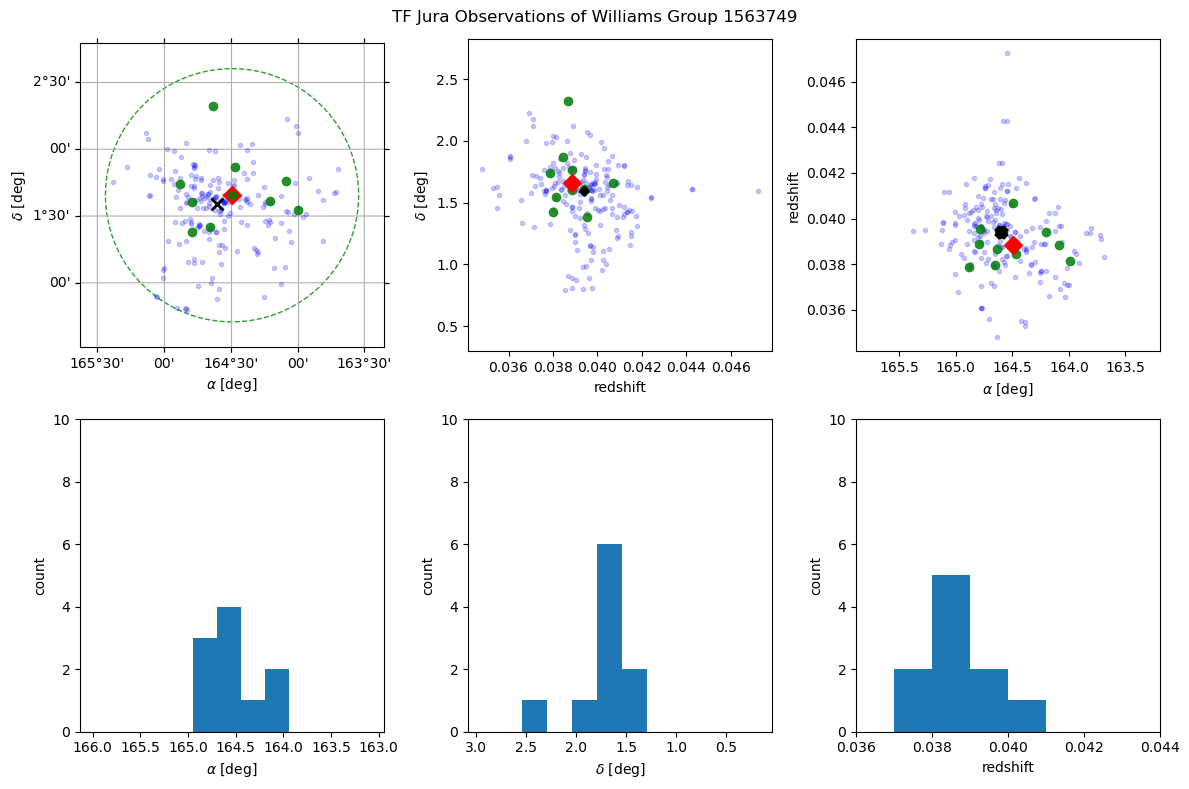

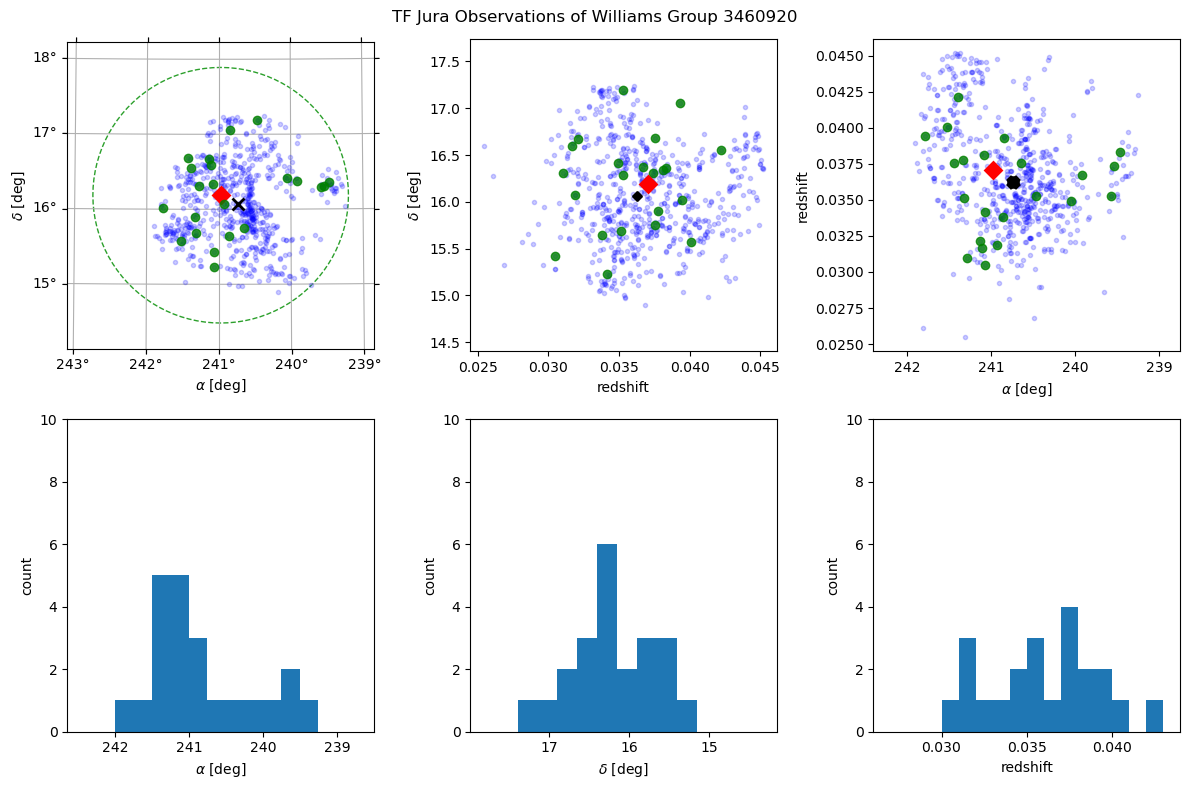

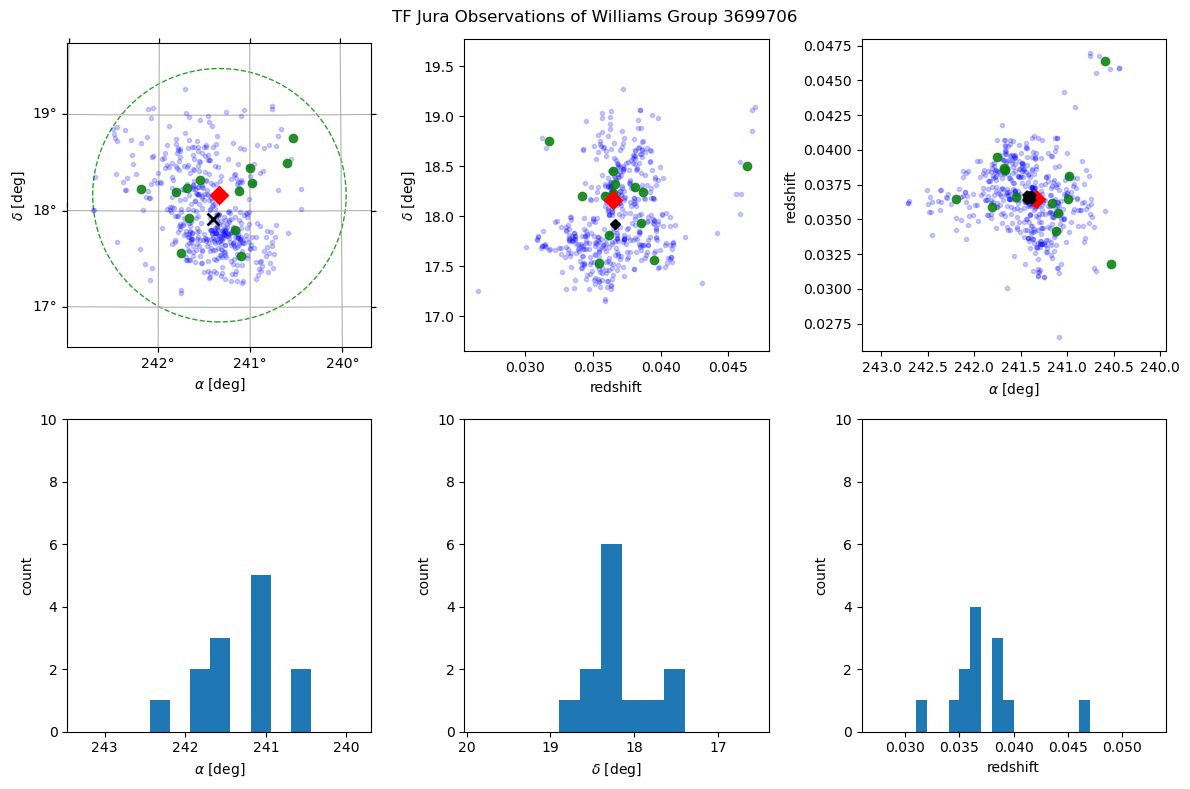

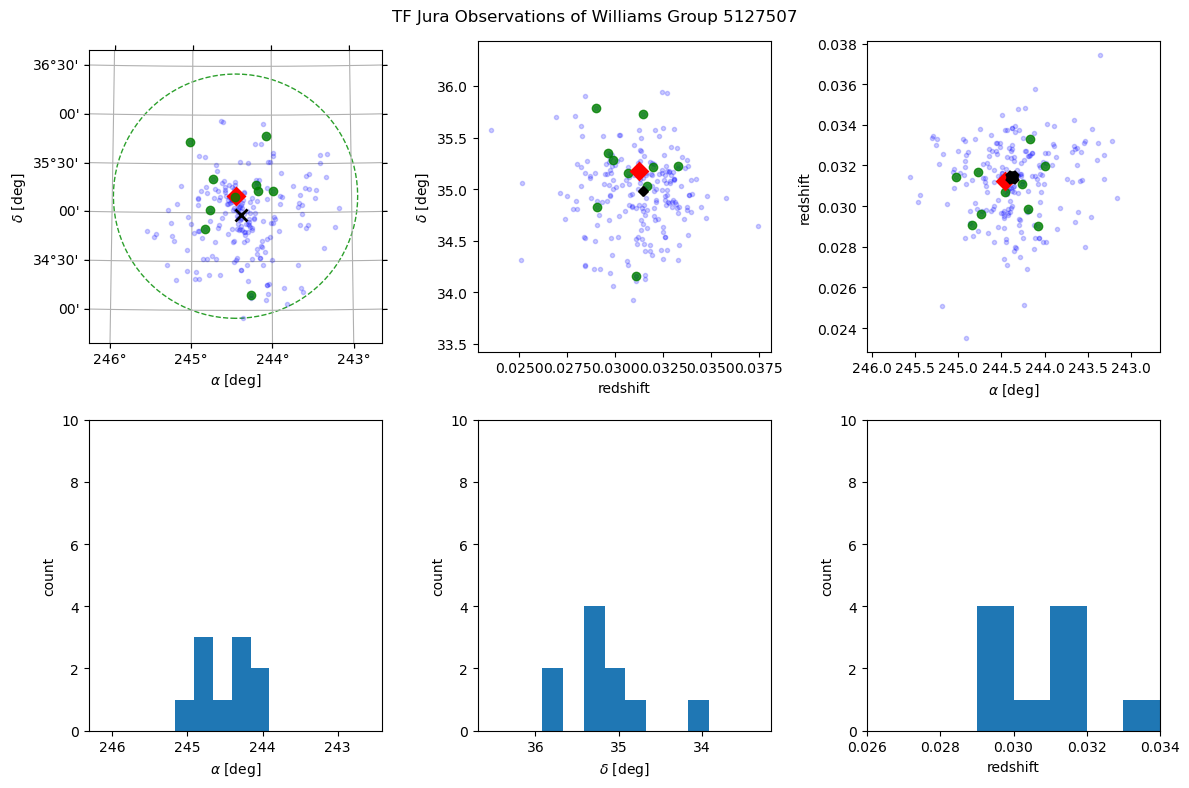

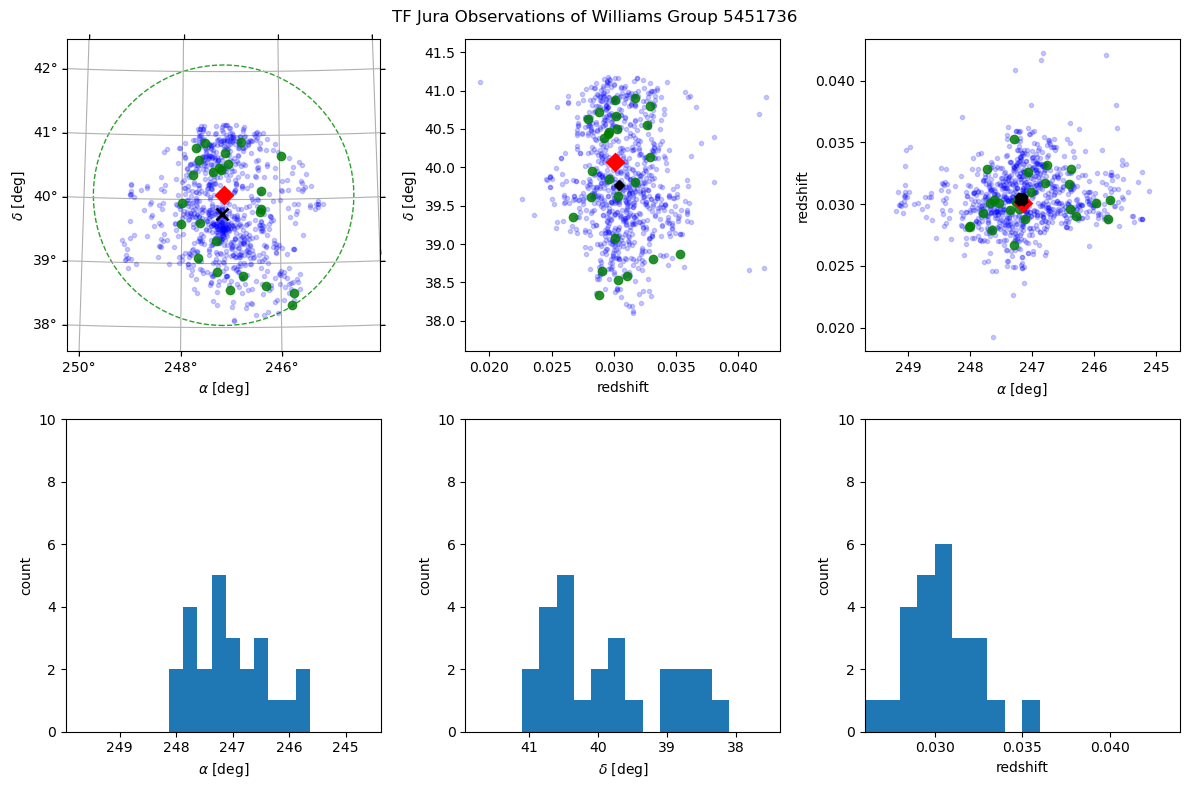

In [14]:
grp_coords_med = []
sga_coords_med = []
z_sga_med = []
z_grp_med = []
z_sga = []
z_grp = []

for cluster_id in sga_groups.keys():
    fig, cluster_center, obs_center, cluster_z_med, obs_z_med, cluster_z, obs_z = plot_cluster_members(clusters, cluster_id, sgatab, sga_groups[cluster_id])
    grp_coords_med.append(cluster_center)
    sga_coords_med.append(obs_center)
    z_sga_med.append(obs_z_med)
    z_grp_med.append(cluster_z_med)
    z_sga.append(obs_z)
    z_grp.append(cluster_z)
    

# Apply Cluster Selection
According to [Korkidis et al.](https://www.aanda.org/articles/aa/full_html/2024/10/aa49704-24/aa49704-24.html), $R_2t$ is 2-3x larger than the virial radius of a group/cluster. So, because the Williams catalog is defined based on halos using the framework of [Tinker (2020)](https://arxiv.org/pdf/2007.12200), the size of the group is going to be based on the virial radius of that halo. For simplicity then, let's set the second turnaround radius to be the distance from the group center to the farthest galaxy assigned to that group.

The selection criteria we will use is:
- $\Delta \theta / \angle R_{2t} < 1$
- $\Delta v / \sigma_p < 1$

where
- $\Delta \theta$ is the angular separation between the median position of the full group, and the median position of our sample galaxies
- $\angle R_{2t}$ is the angular projection of the second turnover radius that we defined above
- $\Delta v$ is the difference between the group velocity and the median velocity of all galaxies assigned to said group
- $\sigma_P$ is the velocity dispersion of the cluster

In [16]:
group_ids = np.asarray(list(sga_groups.keys()))

###### For the angular distance cut
med_sep= []
r2t = []
ang_ratio = []
delta_v = []
sigma_p = []
vel_ratio = []

#### find the separation from the medians of the full group vs. our galaxies
for i in range(len(sga_coords_med)): 
    separation = sga_coords_med[i].separation(grp_coords_med[i])
    med_sep.append(separation)

#### determine our estimate for R2T using the farthest galaxy
for i in range(len(grp_coords_med)): 
    med = grp_coords_med[i]
    idx = np.in1d(sgatab['CLUSTER_ID'], group_ids[i])
    gal = SkyCoord(ra=sgatab['RA'][idx], dec=sgatab['DEC'][idx], unit='deg', frame='icrs')
    r2t.append(np.max(gal.separation(med)))

### calculate the ratio
for n in range(len(med_sep)): 
    ang_ratio.append((med_sep[n]/r2t[n]).value)

############# For the velocity dispersion cut

#### calculate delta v. Using v=cz as a reasonable approx at these low redshifts, we have deltav = c(z_cluster - z_sga)
for j in range(len(z_sga_med)):
    delta_v.append(c_kms*(z_sga_med[j] - z_grp_med[j]))

### find the velocity dispersion of each cluster
for z in range(len(z_grp)): 
    v = c_kms*z_grp[z]
    sp = np.std(v)
    sigma_p.append(sp)

## calculate the ratio
for i in range(len(delta_v)):
    vel_ratio.append(delta_v[i]/sigma_p[i])

###### Apply the selection criteria

ang_ratio = np.asarray(ang_ratio)
vel_ratio = np.asarray(vel_ratio)

dvcut = 1
dthcut = 1
select = (np.abs(vel_ratio) < dvcut) & (ang_ratio < dthcut) 


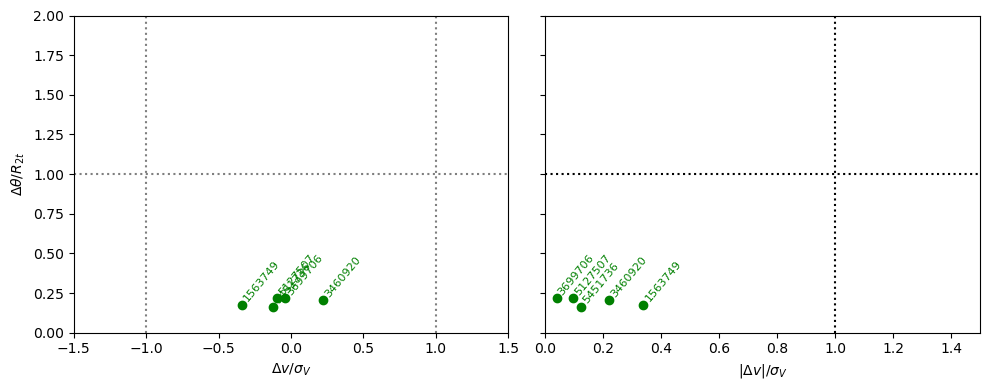

In [17]:

#- Plot results

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True, tight_layout=True)
ax = axes[0]
ax.scatter(vel_ratio[select], ang_ratio[select], color='g')
for _dv, _dth, _id in zip(vel_ratio[select], ang_ratio[select], group_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(vel_ratio[~select], ang_ratio[~select], color='r')
for _dv, _dth, _id in zip(vel_ratio[~select], ang_ratio[~select], group_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k', alpha=0.5)
ax.axvline(-dvcut, ls=':', color='k', alpha=0.5)
ax.axhline(dthcut, ls=':', color='k', alpha=0.5)
ax.set(xlabel=r'$\Delta v/\sigma_V$',
       xlim=(-1.5, 1.5),
       ylabel=r'$\Delta\theta/R_{2t}$',
       ylim=(0,2))

ax = axes[1]
ax.scatter(np.abs(vel_ratio[select]), ang_ratio[select], color='g')
for _dv, _dth, _id in zip(np.abs(vel_ratio[select]), ang_ratio[select], group_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(np.abs(vel_ratio[~select]), ang_ratio[~select], color='r')
for _dv, _dth, _id in zip(np.abs(vel_ratio[~select]), ang_ratio[~select], group_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k')
ax.axvline(-dvcut, ls=':', color='k')
ax.axhline(dthcut, ls=':', color='k')
ax.set(xlabel=r'$|\Delta v|/\sigma_V$',
       xlim=(0, 1.5));


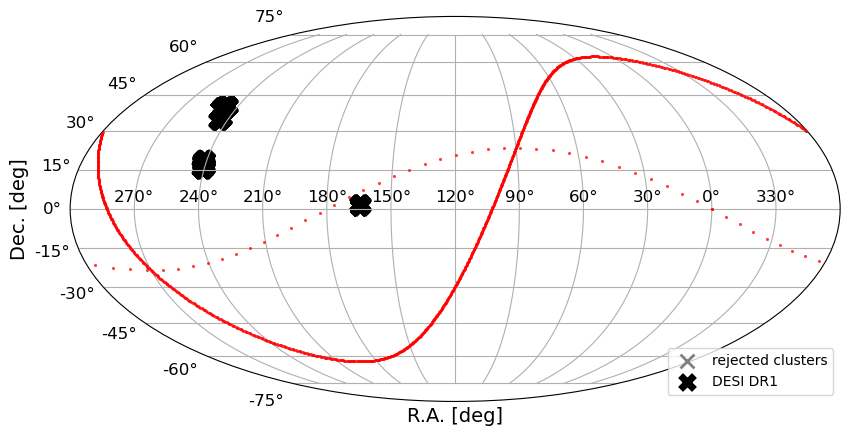

In [18]:
nest_ids = np.asarray(list(sga_groups.keys()))
good_idx = np.in1d(clusters['IGRP'], nest_ids[select])
bad_idx = np.in1d(clusters['IGRP'], nest_ids[~select])
good_cluster_coords = SkyCoord(clusters['RA'][good_idx], clusters['DEC'][good_idx], unit='deg')
bad_cluster_coords = SkyCoord(clusters['RA'][bad_idx], clusters['DEC'][bad_idx], unit='deg')

ax = init_sky()

ax.scatter(ax.projection_ra(bad_cluster_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(bad_cluster_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=2,
           color='gray', 
           label='rejected clusters')
ax.scatter(ax.projection_ra(good_cluster_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(good_cluster_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=5,
           color='black', 
           label='DESI DR1')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.legend(loc='lower right')

plt.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_clusters_AnthonyUpdates_sky.png', dpi=150, facecolor='none');

In [19]:
for i, (cluster_id, sga_ids) in enumerate(sga_groups.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies  {"Y" if select[i] else "N"}')

 1 1563749  10 galaxies  Y
 2 3460920  22 galaxies  Y
 3 3699706  13 galaxies  Y
 4 5127507  10 galaxies  Y
 5 5451736  25 galaxies  Y


## Plot Clusters that Failed

In [17]:
# for cluster_id in sga_clusters.keys():
#     if cluster_id in cluster_ids[~select]:
#         fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
#         # fig.savefig(f'../../Figures/Y3/TF_Y3_cluster_{cluster_id}_reject.png', dpi=150);

## Plot Clusters that Passed

In [18]:
# for cluster_id in sga_clusters.keys():
#     if cluster_id in cluster_ids[select]:
#         fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
#         # fig.savefig(f'../../Figures/Y3/TF_Y3_cluster_{cluster_id}_accept.png', dpi=150);

# Build the Calibration Table of SGA Galaxies in Clusters

In [20]:
caltab = None    # Table of selected clusters and SGA galaxies
rejtab = None    # Table of clusters failing the selection

for cluster_id, sga_ids in sga_groups.items():
    if cluster_id in group_ids[select]:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        caltab = clustertab if caltab is None else vstack([caltab, clustertab])
    else:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        rejtab = clustertab if rejtab is None else vstack([rejtab, clustertab])

# caltab.write('SGA-2020_jura_Vrot_cluster_calib_VI_full_sample.fits', overwrite=True)
caltab[['CLUSTER_ID', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_err']]

CLUSTER_ID,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_err
int64,int64,float64,float64,float64,float64
1563749,323581,14.928427969333717,0.16150483183538306,177.55287307779483,3.2605472575783865
1563749,580774,15.650612440668045,0.06937743543663218,111.797790605644,1.1526675132875355
1563749,660254,15.157533949036152,0.08425849941291612,163.63691081534887,1.2499922439541138
1563749,837825,16.226780887059867,0.1476516960156622,74.28435393295969,4.12328923774541
1563749,849224,15.388808850487694,0.10073038513294727,110.97842420085786,1.377952239002247
1563749,900159,14.96774868951179,0.08438666253031114,120.13123714694439,4.385853683246706
1563749,1142913,14.159948158739134,0.17300334754850252,260.0551723158207,45.682251231002226
1563749,1171905,14.667969408091158,0.130115442728678,28.728518464985868,14.08982344769111
1563749,1209948,14.396570836305619,0.16220218200844394,153.01738124629006,10.544795174406653


In [55]:
# # For if we are just keeping all of them 
# caltab = sgatab[np.isin(sgatab['CLUSTER_ID'], list(sga_groups.keys()))]
# caltab[['CLUSTER_ID', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_err']]

In [21]:
# Save SGA IDs for each cluster that is part of the calibration (for Alex's Bayesian calibration)
for cluster in np.unique(caltab['CLUSTER_ID']):
    output_filename = 'williams/output_' + str(cluster) + '.txt'
    # SGA_IDs_in_cluster = Table()
    # SGA_IDs_in_cluster['SGA_ID'] = c_4r_in_cluster[i]
    caltab[['SGA_ID']][caltab['CLUSTER_ID'] == cluster].write(output_filename, 
                                                              format='ascii.commented_header', 
                                                              overwrite=True)

### VI the galaxies in this sample

In [22]:
# tjura = Table.read('desi_pv_tf_jura_healpix.fits')
# def get_cutout(sgaid, ra, dec, size, verbose=False):
#     """Grab and cache legacy survey cutouts.
    
#     Parameters
#     ----------
#     sgaid : int
#         SGA galaxy ID.
#     ra : float
#         Right ascension (degrees).
#     dec : float
#         Declination (degrees).
#     verbose : bool
#         Add some status messages if true.
        
#     Returns
#     -------
#     img_name : str
#         Name of JPG cutout file written after query.
#     w : astropy.wcs.WCS
#         World coordinate system for the image.
#     """
#     # Either load an existing image or download a cutout.
#     img_name = 'cache/jura_williams_VI/sga_{}.jpg'.format(sgaid)
    
#     if os.path.exists(img_name):
#         if verbose:
#             print('{} exists.'.format(img_name))
#     else:
#         img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
#         print('Get {}'.format(img_url))
            
#         with open(img_name, 'wb') as handle: 
#             response = requests.get(img_url, stream=True) 
#             if not response.ok: 
#                 print(response) 
#             for block in response.iter_content(1024): 
#                 if not block: 
#                     break 
#                 handle.write(block)
                
#     # Set up the WCS.
#     wcs_input_dict = {
#         'CTYPE1': 'RA---TAN',
#         'CUNIT1': 'deg',
#         'CDELT1': -0.262/3600,
#         'CRPIX1': size/2 + 0.5,
#         'CRVAL1': ra,
#         'NAXIS1': size,
#         'CTYPE2': 'DEC--TAN',
#         'CUNIT2': 'deg',
#         'CDELT2': 0.262/3600,
#         'CRPIX2': size/2 + 0.5,
#         'CRVAL2': dec,
#         'NAXIS2': size
#     }
#     w = WCS(wcs_input_dict)
    
#     return img_name, w

# for i in range(len(caltab)):
    
#     # Retrieve SGA ID of galaxy
#     sga_id = caltab['SGA_ID'][i]
    
#     # Coordinates of SGA galaxy's center   
#     ra, dec, z = float(caltab['RA'][i]), float(caltab['DEC'][i]), float(caltab['Z_DESI'][i])
    
#     # D26 in arcmin
#     d26 = caltab['D26'][i]
    
#     #---------------------------------------------------------------------------
#     # Padd the image cutout of the galaxy.
#     # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
#     #print(targetid, sga_id, ra, dec)
#     img_file, wcs = get_cutout(sga_id, ra, dec, size=npix, verbose=False)
#     img = mpl.image.imread(img_file)

#     fig1 = plt.figure(figsize=(7,5))

#     ax = fig1.add_subplot(111, projection=wcs)
#     ax.imshow(np.flip(img, axis=0))
#     ax.set(xlabel='ra', ylabel='dec')
#     ax.text(int(0.02*npix), int(0.85*npix), 'SGA_ID: {}\n$z={{{:.4f}}}$'.format(sga_id, z), fontsize=9, color='yellow')
#     overlay = ax.get_coords_overlay('icrs')
#     overlay.grid(color='white', ls='dotted');
#     #---------------------------------------------------------------------------
    
#     #---------------------------------------------------------------------------
#     # Add the location of the center DESI fiber.
#     # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
#     r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
#                          edgecolor='black', facecolor='none', alpha=0.8, lw=3,
#                          transform=ax.get_transform('icrs'))
#     r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
#                          edgecolor='red', facecolor='none', alpha=0.8, lw=2,
#                          transform=ax.get_transform('icrs'))
#     ax.add_patch(r1)
#     ax.add_patch(r2)
#     #---------------------------------------------------------------------------
    
#     # Find all targets on this galaxy
#     tf_list = tjura[tjura['SGA_ID'] == sga_id]
    
#     # Only keep targets at 0.4R26
#     SGA_coords = SkyCoord(ra=ra, dec=dec, unit=u.degree)
#     target_coords = SkyCoord(ra=tf_list['MEAN_FIBER_RA'], dec=tf_list['MEAN_FIBER_DEC'], unit=u.degree)
#     sep2d = target_coords.separation(SGA_coords)
#     sep2d_r26 = 2*sep2d.to('arcmin')/(d26*u.arcmin)
#     tf_list_0p4 = tf_list[(sep2d_r26 > 0.35) & (sep2d_r26 < 0.45)]

#     for i in range(len(tf_list_0p4)):
#         ra, dec = tf_list_0p4['MEAN_FIBER_RA'][i], tf_list_0p4['MEAN_FIBER_DEC'][i]
        
#         edgecolor2 = 'orange'
        
#         # Add the location of the DESI fibers.
#         # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
#         r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
#                              edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
#                              transform=ax.get_transform('icrs'))
#         r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
#                              edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
#                              transform=ax.get_transform('icrs'))
#         ax.add_patch(r1)
#         ax.add_patch(r2)
        
#         ax.text(ra, dec, str(tf_list_0p4['TARGETID'][i]), 
#                 transform=ax.get_transform('icrs'), 
#                 color='white', 
#                 path_effects=[patheffects.withStroke(linewidth=1, foreground='black')])
    
#     fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
#     fig1.savefig('cache/jura_williams_VI/dist_{}.png'.format(sga_id), dpi=120)
#     fig1.show()
#     fig1.clear()
#     plt.close(fig1)
    

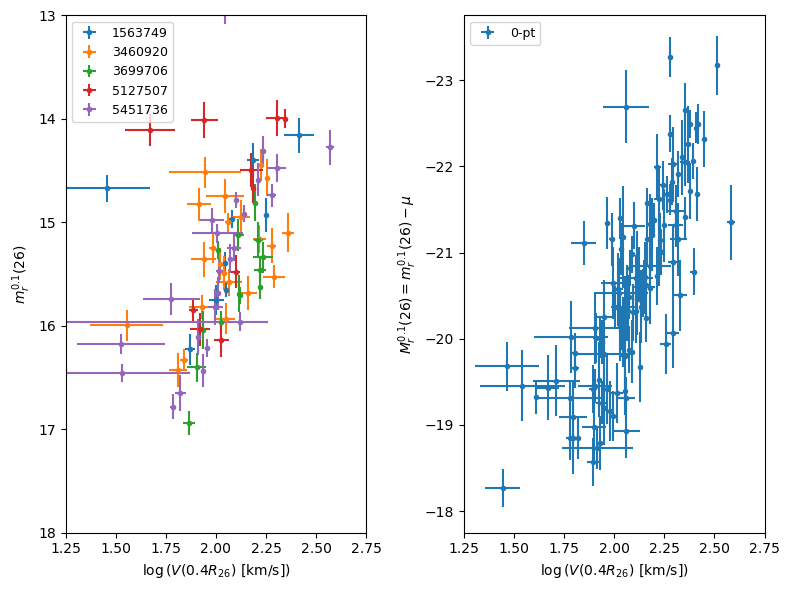

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

# #- Plot galaxies with failed cluster selections. (there are none)
# _cluster_ids = np.unique(rejtab['CLUSTER_ID'])
# markers = 'sDv^<>'
# for j, _cluster_id in enumerate(_cluster_ids):
#     select_cluster = np.in1d(rejtab['CLUSTER_ID'], _cluster_id)

#     #- Store independent variable for each cluster
#     logv = np.log10(rejtab['V_0p4R26'][select_cluster].data) - logV0
#     logv_err = 0.434*rejtab['V_0p4R26_err'][select_cluster].data / rejtab['V_0p4R26'][select_cluster].data

#     #- Store dependent variable for each cluster
#     mr26 = rejtab['R_MAG_SB26_CORR'][select_cluster].data
#     mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
#     ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
#                 fmt=markers[j % 6], markersize=6, color='gray', alpha=0.3, label=f'{_cluster_id} (rej.)')

#- Plot galaxies and clusters passing all selections.
_cluster_ids = np.unique(caltab['CLUSTER_ID'])

for _cluster_id in _cluster_ids:
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_err'][select_cluster].data / caltab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_cluster].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_cluster_id}')

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[18, 13],
       ylabel=r'$m_r^{0.1} (26)$')
ax.legend(loc='upper left', fontsize=9)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_err'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_err'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[-17.75, -23.75],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='upper left', fontsize=9);

# # fig.savefig('Figures/TF_Y3_cluster_calibration_0pt.png', dpi=150);

# Apply the Joint TFR Fit

In [25]:
#- Extract successful clusters
_cluster_ids = np.unique(caltab['CLUSTER_ID'])
m = len(_cluster_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

# logV0 = 2.25
logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_err'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_err'])
weights.append(np.array(1/zeroptab['MAX_VOL_FRAC']))

#- Loop over the SGA clusters
for k, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_cluster]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_err'][select_cluster] / caltab['V_0p4R26'][select_cluster])
    mag.append(caltab['R_MAG_SB26_CORR'][select_cluster])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_cluster])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_cluster]))

logV0 = 2.0713926182429763


In [26]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -22273.448074947733
     jac: array([-0.01236913, -0.02801243,  0.00181899,  0.00181899, -0.01564331,
        0.        ,  0.00472937, -0.08330971])
 message: 'Optimization terminated successfully.'
    nfev: 10686
     nit: 87
 success: True
       x: array([ -7.25046582, -20.32586276,  15.3581954 ,  15.33100148,
        15.78595797,  14.94681052,  15.26885245,   0.98569016])
Ndim: 8 6


100%|██████████| 1000/1000 [00:10<00:00, 94.01it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.94245134 45.34170365 45.45869059 48.78931307 49.833127   51.59080792
 54.38876894 46.33270929] / 2719.4384471417225


100%|██████████| 1000/1000 [00:12<00:00, 79.65it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [55.6975292  52.32258758 54.65715309 59.41467805 59.532879   66.36340572
 59.69872684 50.76338528] / 3318.170286096459


100%|██████████| 1000/1000 [00:12<00:00, 81.26it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [67.54562113 60.3587985  70.16691509 65.67924418 66.90623754 64.57399882
 62.41911202 60.26015765] / 3508.3457544074226


100%|██████████| 1000/1000 [00:11<00:00, 88.81it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [71.01931456 59.87270076 79.90510581 75.63045331 80.39446858 66.68445109
 63.665939   65.79204103] / 4019.723428847437


100%|██████████| 1000/1000 [00:12<00:00, 80.67it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [78.77852256 67.54574353 84.86582071 80.39465682 74.0895928  68.75479545
 65.26061623 77.61190747] / 4243.291035420593


100%|██████████| 1000/1000 [00:10<00:00, 93.71it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [77.79045789 69.85567929 78.62187556 79.62248472 72.92684677 76.56013773
 64.03975195 79.37703724] / 3981.1242361941927


100%|██████████| 1000/1000 [00:10<00:00, 91.74it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [78.55718505 67.37926085 70.56906998 82.6314451  69.32963896 82.99592634
 78.25495901 77.89539118] / 4149.796317020757


100%|██████████| 1000/1000 [00:13<00:00, 71.75it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [73.49757195 65.17985885 72.74280598 74.5747408  69.33156636 78.30498131
 85.33298228 75.46179731] / 4266.649113897731


100%|██████████| 1000/1000 [00:12<00:00, 78.43it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [71.58825588 69.77538381 74.55644589 66.29533299 66.48475135 82.73869332
 83.90583879 77.76139325] / 4195.291939456882


100%|██████████| 1000/1000 [00:15<00:00, 66.37it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [71.59568912 70.79904091 76.77373257 68.07053296 74.3837775  79.59874678
 92.90189135 76.29707843] / 4645.094567683348


100%|██████████| 1000/1000 [00:12<00:00, 82.99it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [72.83938184 72.85592713 76.5101603  70.86238042 74.97822241 88.79464158
 93.66248771 75.5717354 ] / 4683.124385600482


100%|██████████| 1000/1000 [00:11<00:00, 89.67it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [72.15378744 73.30364465 80.04984551 70.36184964 73.52077912 90.31361424
 93.0901416  73.86897083] / 4654.507079835657


In [27]:
temp_outfile = open('cov_ab_jura_jointTFR_varyV0_binaryML_weightsVmax-1_williams_Y3.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

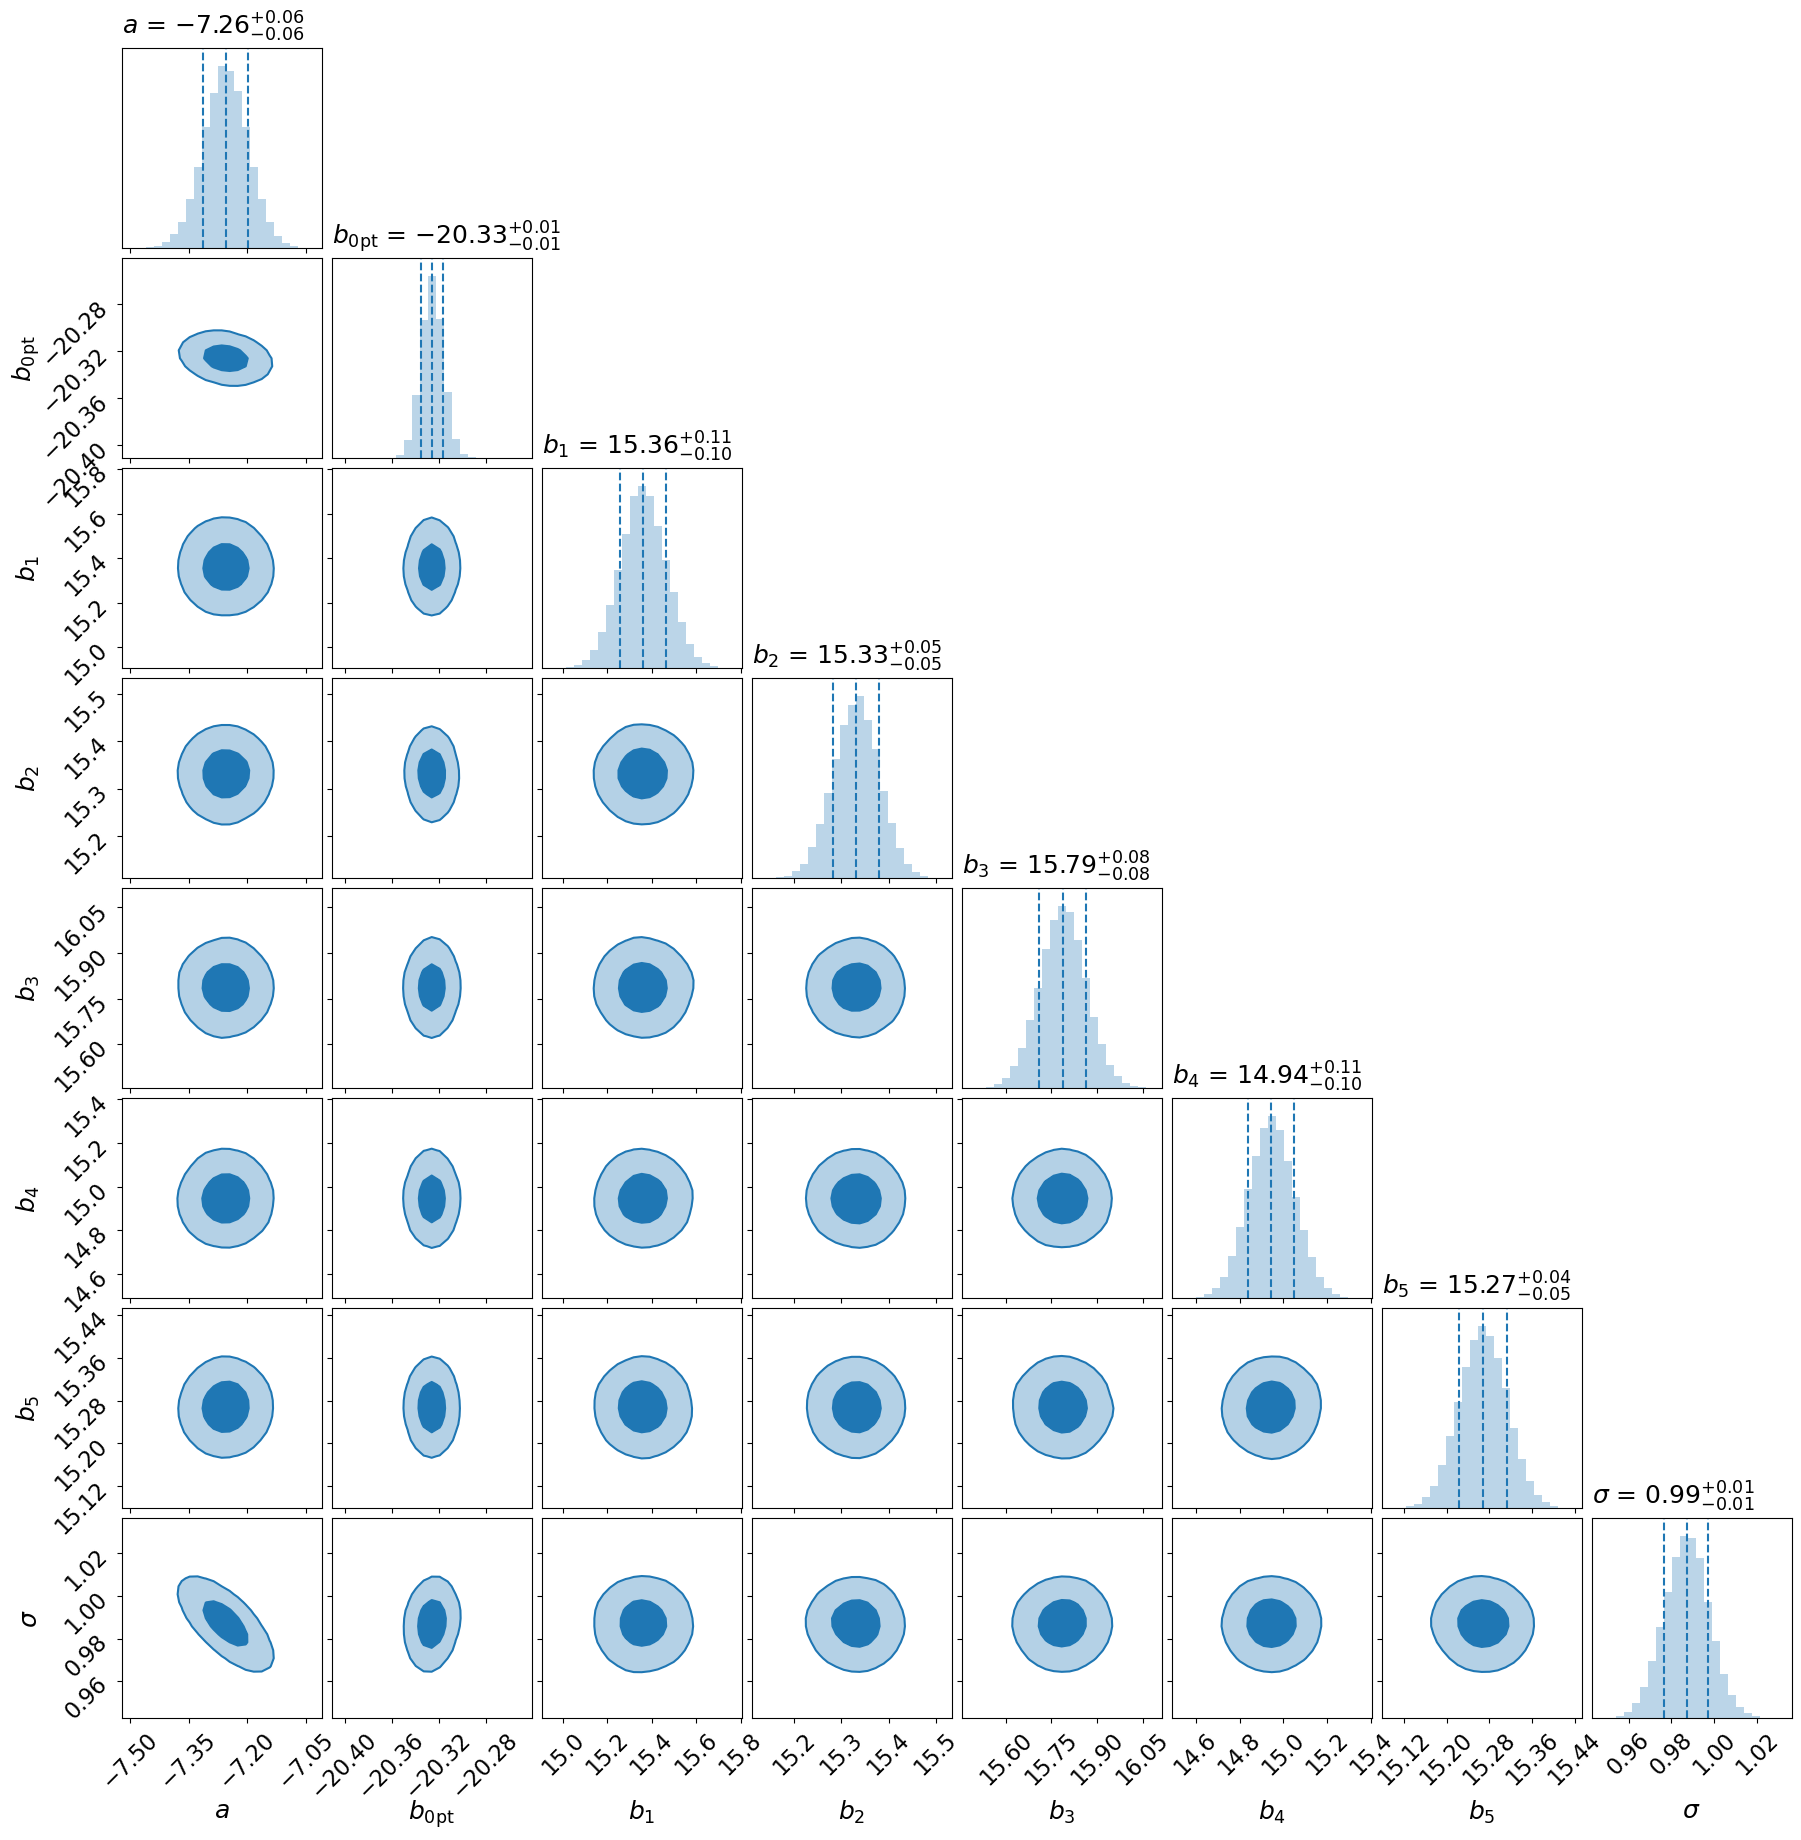

In [28]:
### Full corner plot
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)
# fig.savefig('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/Figures/TF_Y3_cluster_calibration_binaryML_corner0_weightsVmax-1.png', dpi=150);

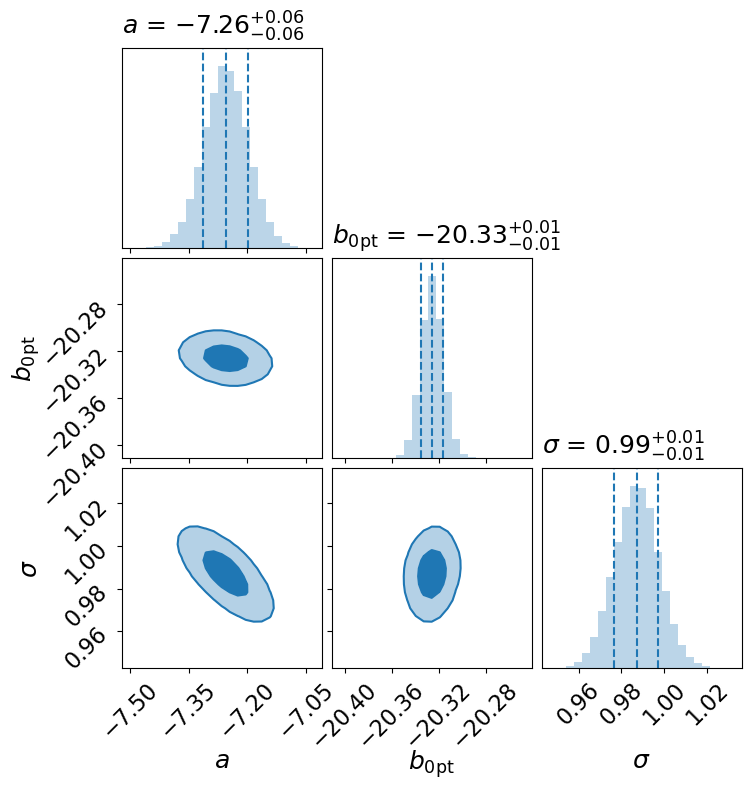

In [29]:
##### Cornerplot with just slope, zero point, and scatter
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$']
labels += [r'$\sigma$']

param_indices = [0, 1, tfr_mcmc_samples.T.shape[1] - 1]


fig = corner(tfr_mcmc_samples.T[:, param_indices], bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)
# fig.savefig('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/Figures/TF_Y3_cluster_calibration_binaryML_corner0_weightsVmax-1_williams_Y3.png', dpi=150);

In [27]:
# # Read in the pickle file with the fit

# # Open the pickle file and load the data
# with open('cov_ab_jura_jointTFR_varyV0_binaryML_full_sample.pickle', 'rb') as temp_infile:
#     cov_tfr, tfr_mcmc_samples, logV0 = pickle.load(temp_infile)

# # Now the variables cov_tfr, tfr_mcmc_samples, and logV0 are defined and available to use


In [28]:
# fig.savefig('/global/homes/s/sgmoore1/DESI_SGA/TF/Y3/Figures/TF_Y3_cluster_calibration_binaryML_corner0.png', dpi=150);

### Plot the HyperFit Results

In [30]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

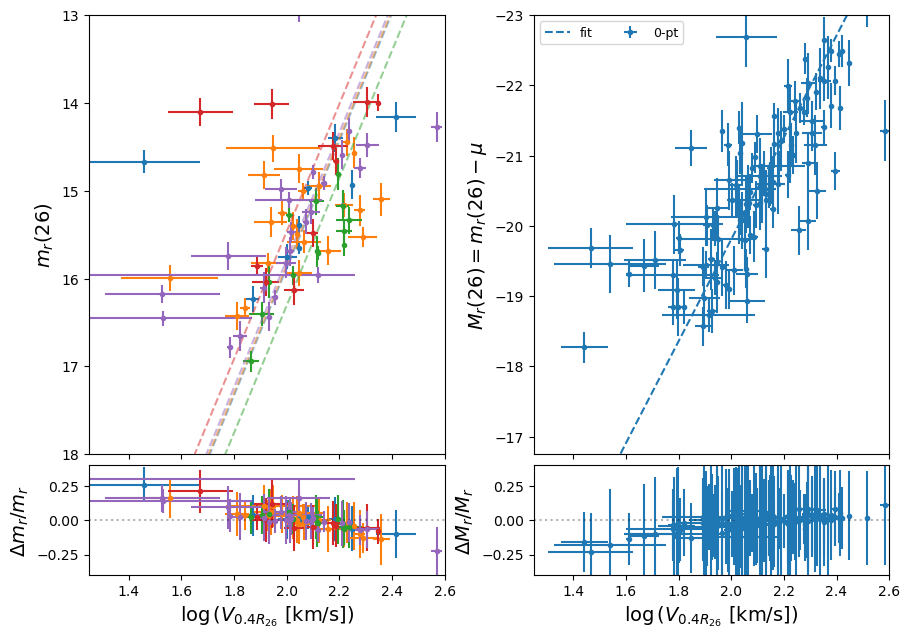

In [31]:
fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot clusters
ax = axes[0,0]

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', )
                     # label=f'{_cluster_ids[k]}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5, label='fit')

ax.set(xlim=[1.25, 2.75],
       ylim=[18, 13])
ax.set_ylabel(r'$m_r (26)$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--', label='fit')
ax.set(xlim=[1.25, 2.75],
       ylim=[-16.75, -23])
ax.set_ylabel(r'$M_r(26) = m_r(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)

#- Plot residuals: clusters
ax = axes[1,0]

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[0], yerr=mag_err[0],
                     fmt='.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);
# fig.savefig('Figures/TF_Y3_cluster_calibration_0pt_binaryML_fit_full_sample.png', dpi=150)

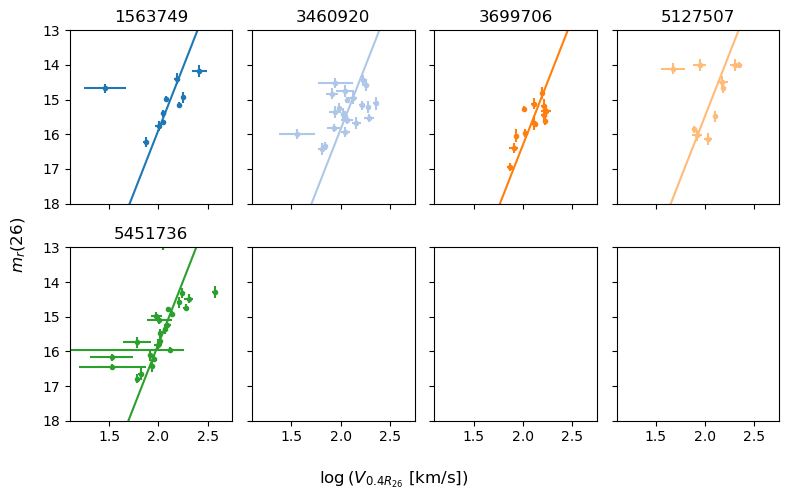

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(8,5), tight_layout=False)

color = iter(plt.get_cmap('tab20').colors)
for i in range(m):
    c = plt.get_cmap('tab20').colors[i % 20]
    
    row = int(i/4)
    col = i%4
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.1, 2.75], ylim=[18, 13], title=f'{_cluster_ids[i]}')
    
fig.supxlabel(r'$\log{(V_{0.4R_{26}}~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r (26)$');
# plt.savefig('Figures/Y3_Individual_Cluster_Fits_full_sample.png')

## Check for Dwarf Galaxies

In [33]:
logV_n17 = (-17 - b0pt)/a_ + logV0
# b_perp = -17 + (logV_n17 - logV0)/a_
# b_perp

mr_n17 = a_*(logV_n17 - logV0) + b_
b_perp = mr_n17 + (logV_n17 - logV0)/a_

print(10**logV_n17, 'km/s')

41.01955882760088 km/s


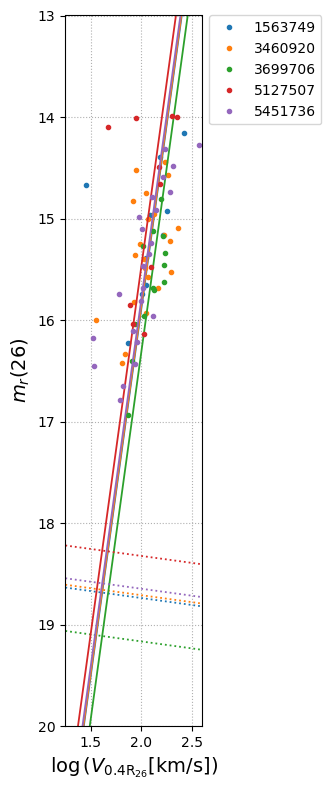

In [34]:
plt.figure(figsize=(4,8), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

for k in range(m):
    eb = plt.plot(logV[k+1] + logV0, mag[k+1], '.', label=f'{_cluster_ids[k]}')
    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), marker='None', ls='-', lw=1.3)
    plt.plot(_logv + logV0, -_logv/a_ + b_perp[k], color=eb[0].get_color(), marker='None', ls=':', lw=1.3)
    # plt.hlines(m_dwarf_clusters[_cluster_ids[k]], 1.25, 2.75, colors=eb[0].get_color(), linestyles='dashed')
    
plt.xlabel(r'$\log{(V_\mathrm{0.4R_{26}} [\mathrm{km/s}])}$', fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.xlim(1.25, 2.6)
plt.ylim(20, 13)

plt.gca().set_aspect('equal');

In [35]:
##### Filter out any of these dwarves

dwarfs = np.zeros(len(caltab), dtype=bool)

for i in range(m):
    # Retrieve this cluster's nest ID
    nestid = _cluster_ids[i]
    
    # Find all galaxies in this cluster
    cluster_gal_idx = caltab['CLUSTER_ID'] == nestid
    
    # Find which of these cluster galaxies are dwarfs
    cluster_dwarfs = (caltab['R_MAG_SB26_CORR'][cluster_gal_idx] - caltab['R_MAG_SB26_ERR_CORR'][cluster_gal_idx]) > (-(np.log10(caltab['V_0p4R26'][cluster_gal_idx]) - logV0)/a_ + b_perp[i])
    
    # Set the boolean correctly
    dwarfs[cluster_gal_idx] = cluster_dwarfs
    
caltab_bright = caltab[~dwarfs]

print(np.sum(dwarfs))

0
